# Supervised Learning Capstone Project - Tree Methods Focus 

GOAL: Create a model to predict whether or not a customer will Churn

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Data

### Load

In [2]:
df = pd.read_csv('data/Telco-Customer-Churn.csv')
df.sample(5)

customerID  gender  SeniorCitizen Partner Dependents  tenure  \
206   6348-SNFUS    Male              0     Yes        Yes      72   
2485  7641-TQFHN    Male              0      No        Yes      39   
2452  5198-EFNBM    Male              1     Yes         No      57   
6228  7153-OANIO    Male              0      No         No       1   
6472  9389-ACWBI  Female              0     Yes        Yes       5   

     PhoneService     MultipleLines InternetService OnlineSecurity  ...  \
206            No  No phone service             DSL            Yes  ...   
2485          Yes               Yes     Fiber optic             No  ...   
2452          Yes                No     Fiber optic             No  ...   
6228          Yes                No     Fiber optic             No  ...   
6472          Yes                No     Fiber optic             No  ...   

     DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
206               Yes         Yes          No             Yes        Two year   
2485               No         Yes         Yes             Yes        Two year   
2452              Yes          No         Yes              No        One year   
6228               No          No          No              No  Month-to-month   
6472               No          No          No              No  Month-to-month   

     PaperlessBilling            PaymentMethod MonthlyCharges  TotalCharges  \
206               Yes  Credit card (automatic)          55.45       4179.20   
2485               No             Mailed check         100.55       3895.35   
2452              Yes         Electronic check          90.65       5199.80   
6228               No         Electronic check          69.95         69.95   
6472               No  Credit card (automatic)          69.95        320.40   

      Churn  
206      No  
2485     No  
2452     No  
6228    Yes  
6472     No  

[5 rows x 21 columns]

### How it looks? -- A lot of catagorical features

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   gender            7032 non-null   object 
 2   SeniorCitizen     7032 non-null   int64  
 3   Partner           7032 non-null   object 
 4   Dependents        7032 non-null   object 
 5   tenure            7032 non-null   int64  
 6   PhoneService      7032 non-null   object 
 7   MultipleLines     7032 non-null   object 
 8   InternetService   7032 non-null   object 
 9   OnlineSecurity    7032 non-null   object 
 10  OnlineBackup      7032 non-null   object 
 11  DeviceProtection  7032 non-null   object 
 12  TechSupport       7032 non-null   object 
 13  StreamingTV       7032 non-null   object 
 14  StreamingMovies   7032 non-null   object 
 15  Contract          7032 non-null   object 
 16  PaperlessBilling  7032 non-null   object 


### Any missing values? -- None (but check for garbage)

In [4]:
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

### Any garbage values? -- None

In [5]:
cols = df.columns
cat_cols = df.select_dtypes(include='object').columns
num_cols = df.select_dtypes(exclude='object').columns
print(cat_cols, '\n', num_cols)

Index(['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn'],
      dtype='object') 
 Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')


In [6]:
for c in cat_cols[1:]: # ignoring customerID
    print(f"{c} : {df[c].unique()}")

gender : ['Female' 'Male']
Partner : ['Yes' 'No']
Dependents : ['No' 'Yes']
PhoneService : ['No' 'Yes']
MultipleLines : ['No phone service' 'No' 'Yes']
InternetService : ['DSL' 'Fiber optic' 'No']
OnlineSecurity : ['No' 'Yes' 'No internet service']
OnlineBackup : ['Yes' 'No' 'No internet service']
DeviceProtection : ['No' 'Yes' 'No internet service']
TechSupport : ['No' 'Yes' 'No internet service']
StreamingTV : ['No' 'Yes' 'No internet service']
StreamingMovies : ['No' 'Yes' 'No internet service']
Contract : ['Month-to-month' 'One year' 'Two year']
PaperlessBilling : ['Yes' 'No']
PaymentMethod : ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn : ['No' 'Yes']


## EDA

### Is the data balanced? -- Okayish (mildly imbalanced)

No     5163
Yes    1869
Name: Churn, dtype: int64


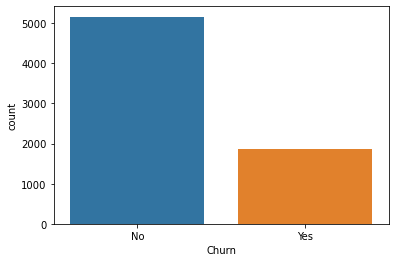

In [7]:
print(df['Churn'].value_counts())
sns.countplot(data=df, x='Churn');

### Box plot -- alot of people with 1 and 2 yr contracts and higher TotalCharges tend to Churn!

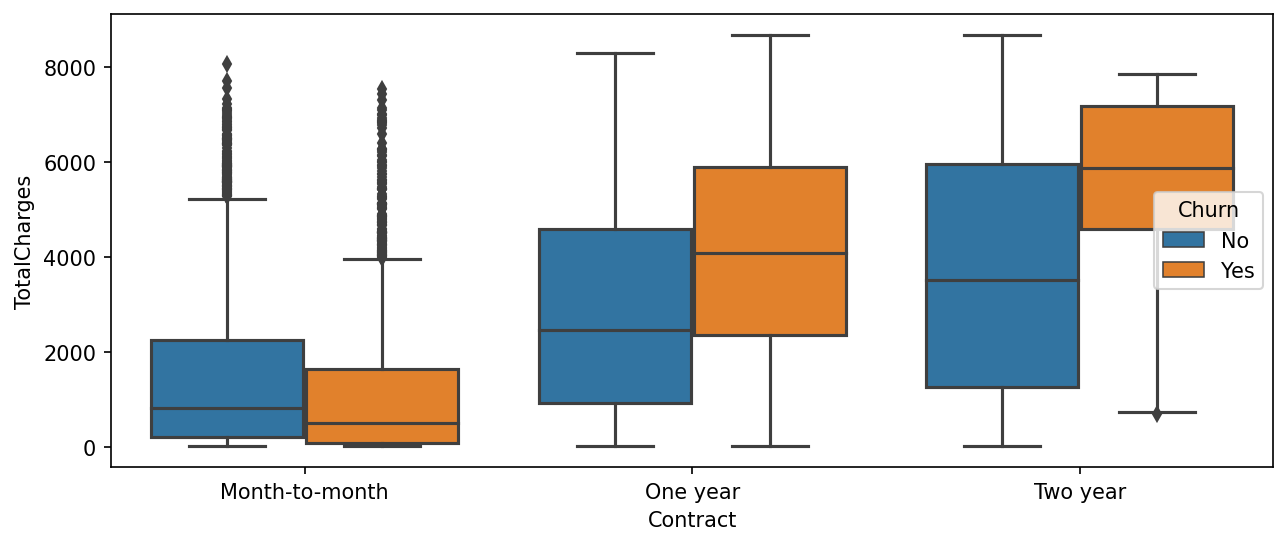

In [8]:
plt.figure(figsize=(10,4),dpi=150)
sns.boxplot(x='Contract', y='TotalCharges', data=df, hue='Churn');

### Let's get dummies an make a barplot of the correlation wrt Churn_Yes -- while month-to-month contrart is closely related to Churn_yes, the 2 yr contract is not related to Churn_yes!  

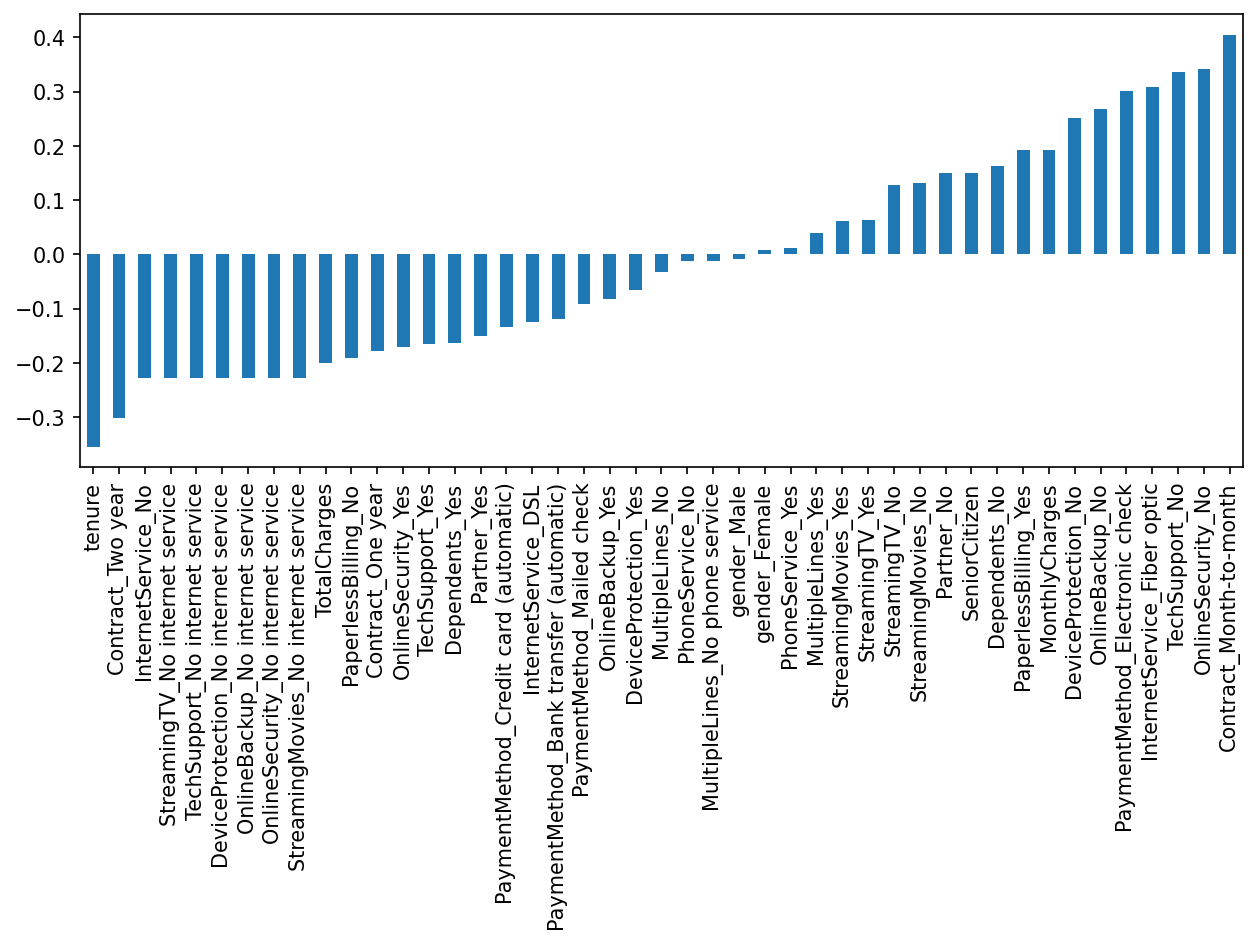

In [9]:
df_new = df.drop('customerID', axis=1) # customerID not useful feature
df_new = pd.get_dummies(data=df_new)   # drop_firt skipped for better visualization
plt.figure(figsize=(10,4),dpi=150)
df_new.corr()['Churn_Yes'].sort_values()[1:-1].plot(kind='bar');

### Churn analysis

Segementing customers based on their tenure, creating "cohorts", allowing us to examine differences between customer cohort segments.

In [10]:
df['Contract'].unique(), df['tenure'].unique()

(array(['Month-to-month', 'One year', 'Two year'], dtype=object),
 array([ 1, 34,  2, 45,  8, 22, 10, 28, 62, 13, 16, 58, 49, 25, 69, 52, 71,
        21, 12, 30, 47, 72, 17, 27,  5, 46, 11, 70, 63, 43, 15, 60, 18, 66,
         9,  3, 31, 50, 64, 56,  7, 42, 35, 48, 29, 65, 38, 68, 32, 55, 37,
        36, 41,  6,  4, 33, 67, 23, 57, 61, 14, 20, 53, 40, 59, 24, 44, 19,
        54, 51, 26, 39]))

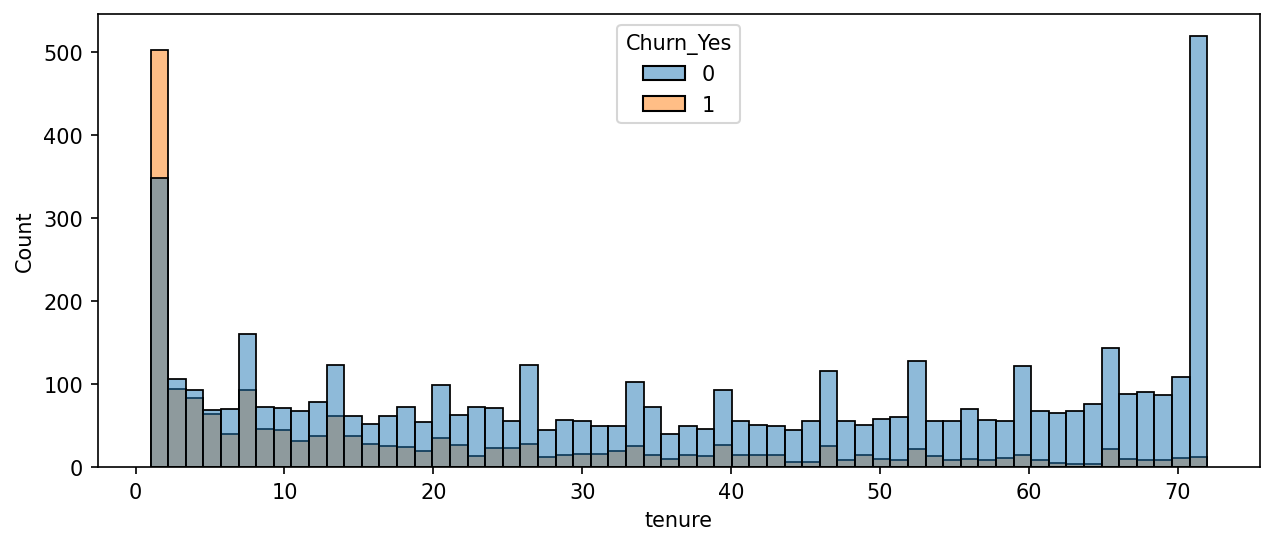

In [11]:
plt.figure(figsize=(10,4),dpi=150)
sns.histplot(x='tenure', data=df_new, bins=60, hue='Churn_Yes');

- There are also a lot of customers with tenures of about a few months and also for more than 70 months!
- Then, there are small peaks at the around the yearly contracts!  

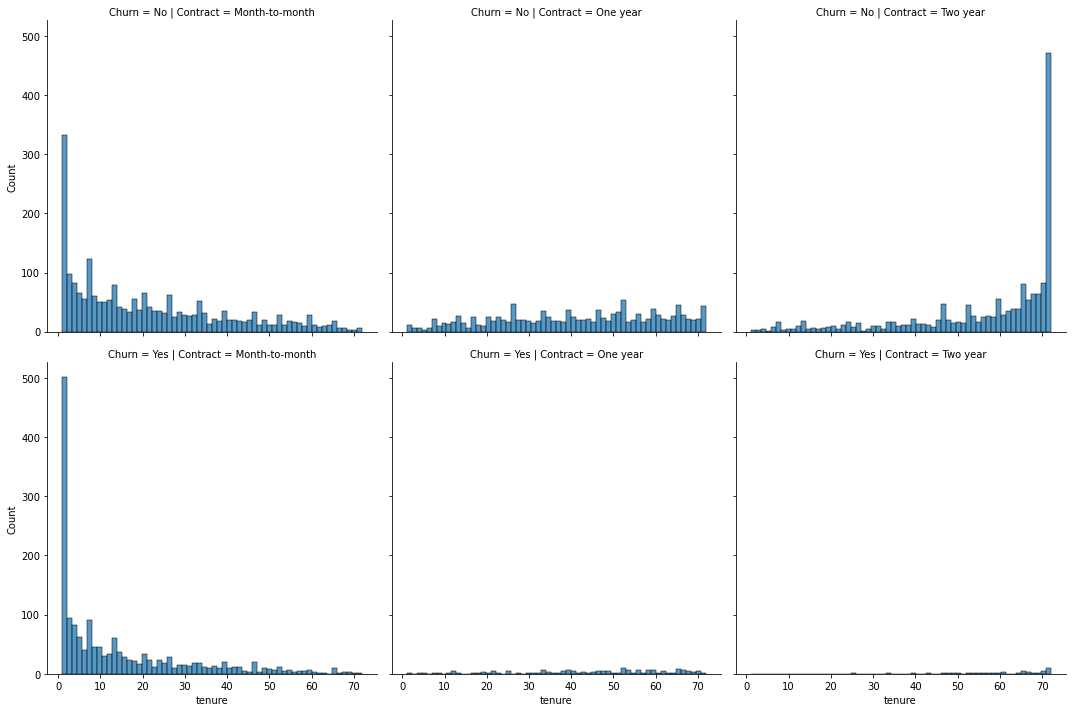

In [12]:
sns.displot(data=df, bins=60, x='tenure', col='Contract', row='Churn');

- A lot of customers are having a tenure of only a few months tend to Churn!
- While, customers with 1,2 yr contracts tent NOT to Churn!

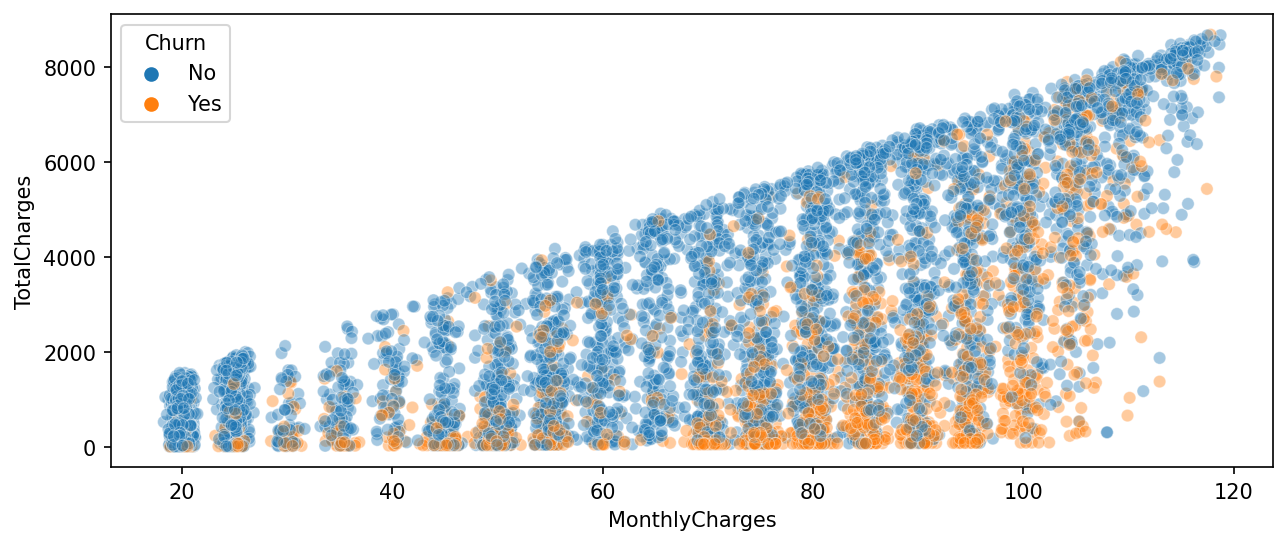

In [13]:
plt.figure(figsize=(10,4), dpi=150)
sns.scatterplot(data=df, x='MonthlyCharges', y='TotalCharges', hue='Churn',
                alpha=0.4, lw=0.3);

- A lot of people Churn when their MonthlyCharges are higher!

#### Creating cohorts based on tenure

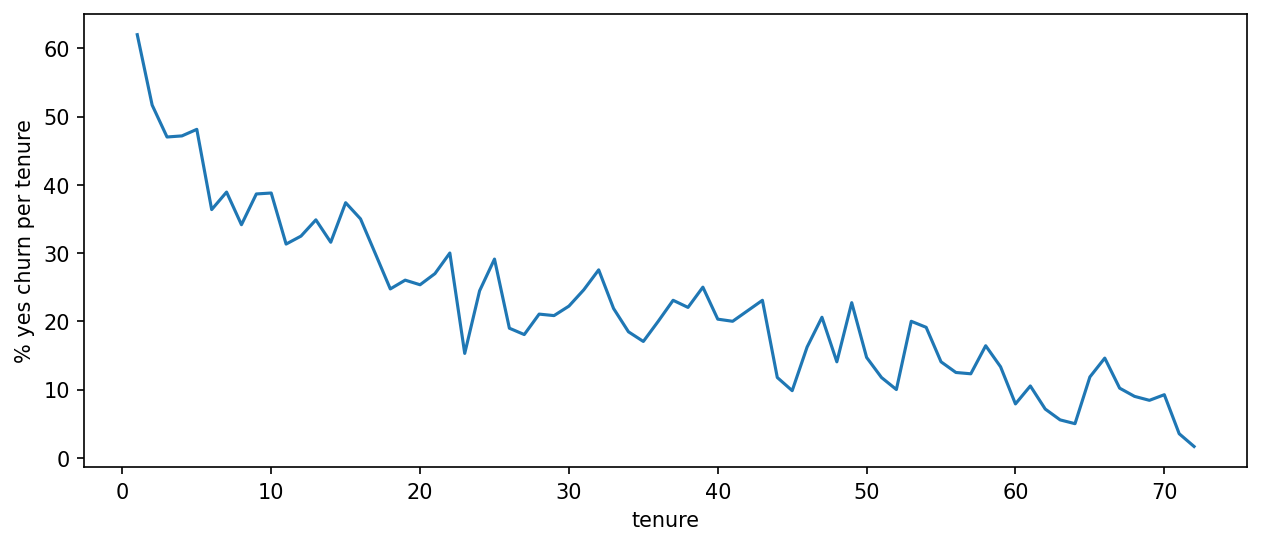

In [14]:
yes_churn = df[df['Churn']=='Yes'].groupby('tenure').count()['Churn']
no_churn  = df[df['Churn']=='No'].groupby('tenure').count()['Churn']

plt.figure(figsize=(10,4), dpi=150)
((yes_churn*100)/(yes_churn+no_churn)).plot();
plt.ylabel('% yes churn per tenure');


#### Creating brader cohort groups
   * '0-12 Months'
   * '12-24 Months'
   * '24-48 Months'
   * 'Over 48 Months'

In [15]:
def cohort(tenure):
    if tenure <=12:
        return '0-12 Months'
    elif tenure <=24:
        return '12-24 Months'
    elif tenure <=48:
        return '24-48 Months'
    else:
        return 'Over 48 Months'

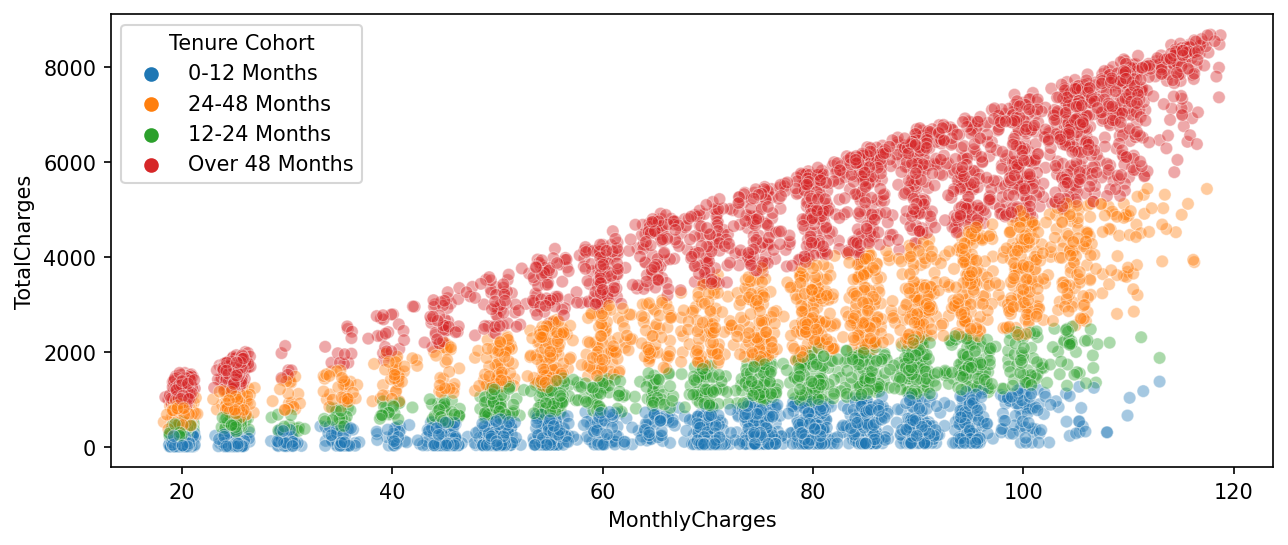

In [16]:
df['Tenure Cohort'] = data=df['tenure'].apply(cohort)

plt.figure(figsize=(10,4), dpi=150);
sns.scatterplot(data=df, x='MonthlyCharges', y='TotalCharges', hue='Tenure Cohort',
                alpha=0.4, lw=0.3);

<Figure size 1500x600 with 0 Axes>

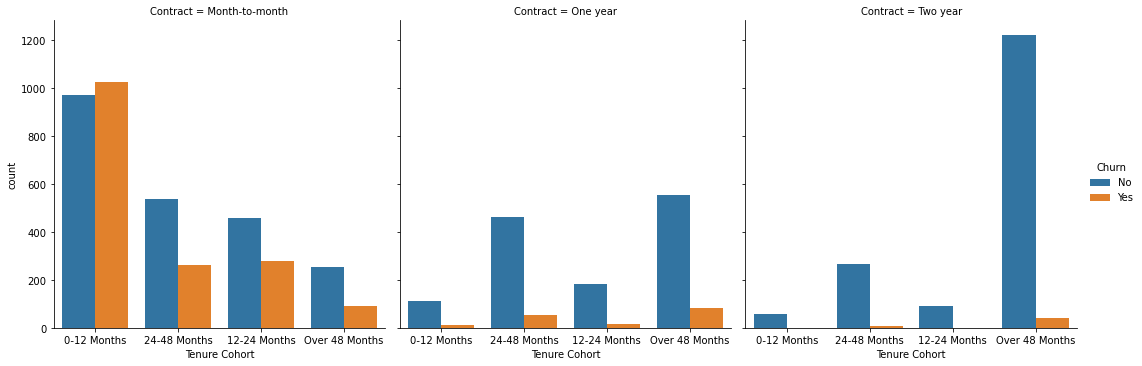

In [17]:
plt.figure(figsize=(10,4), dpi=150);
sns.catplot(data=df, x='Tenure Cohort', hue='Churn', kind='count', col='Contract');

- People staying for more than over 48 months are less likely to churn
- While, people staying for less than 12 months are very likely to churn
- Poeple with Month-to-month contract are more likely to churn vs people with 1,2 yr contracts!
  

## Tree Based Classification

### Get relevant features and output

In [18]:
X = df.drop(['customerID', 'Churn'], axis=1)
X = pd.get_dummies(X, drop_first=True)
y = df['Churn']

### Split into train and test datasets

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = \
train_test_split(X, y, test_size=0.1, random_state=101)

### Helper

In [20]:
from sklearn.metrics import classification_report, plot_confusion_matrix

def post_process(grid):
    print('Best Model')
    print(grid.best_params_)
    y_pred = grid.predict(X_test)

    print('Classification Report')
    print(classification_report(y_test, y_pred))
    plot_confusion_matrix(grid, X_test, y_test);

    imp_feats = pd.DataFrame(data=grid.best_estimator_.feature_importances_, 
                         index=X.columns, columns=['ImpFeat'])
                         
    imp_feats =  imp_feats.sort_values('ImpFeat')
    imp_feats = imp_feats[imp_feats['ImpFeat']>0.0]
    plt.figure(figsize=(10,4))
    sns.barplot(data=imp_feats, x=imp_feats.index, y='ImpFeat');
    plt.xticks(rotation=90);

### 1. Decision Tree

Best Model
{'max_depth': 5, 'min_samples_split': 5}
Classification Report
              precision    recall  f1-score   support

          No       0.86      0.89      0.87       557
         Yes       0.52      0.44      0.47       147

    accuracy                           0.80       704
   macro avg       0.69      0.66      0.67       704
weighted avg       0.79      0.80      0.79       704



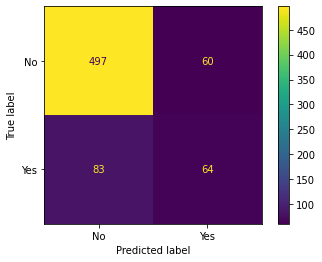

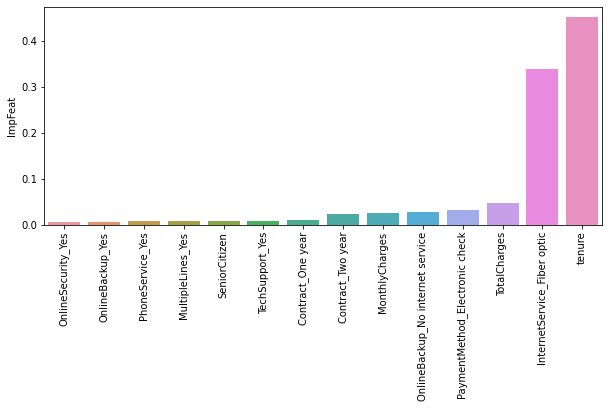

In [32]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=101)

from sklearn.model_selection import GridSearchCV
param_grid = {
              'max_depth':[2,5,10],
              'min_samples_split':[2,5,10,20],
            #   'max_leaf_nodes':[20,30,40]
             }

dt_grid = GridSearchCV(dt,param_grid,cv=5,scoring='recall_macro',n_jobs=8)
dt_grid.fit(X_train,y_train)

post_process(dt_grid)

- Decision tree is performing good on No Churn as it has more rows of data!
- A lot of False Negatives!

### 2. Random Forest

Best Model
{'min_samples_split': 0.01, 'n_estimators': 500}
Classification Report
              precision    recall  f1-score   support

          No       0.87      0.93      0.90       557
         Yes       0.64      0.49      0.55       147

    accuracy                           0.84       704
   macro avg       0.76      0.71      0.73       704
weighted avg       0.82      0.84      0.83       704



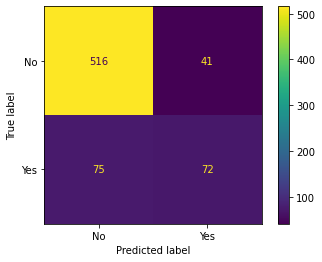

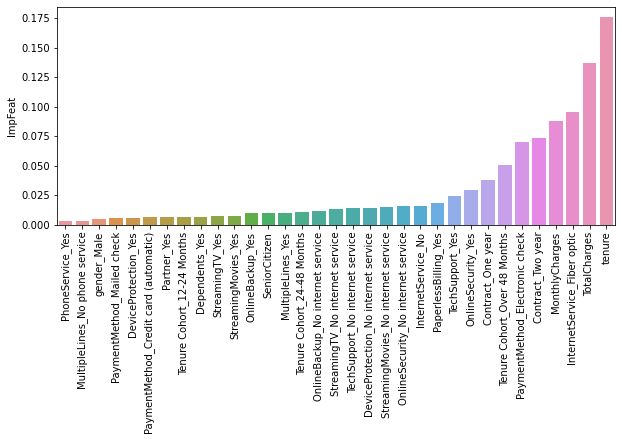

In [73]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=101, bootstrap=True)

from sklearn.model_selection import GridSearchCV
param_grid = {'n_estimators':[500],
              'min_samples_split':[0.01,0.05]
             }

rf_grid = GridSearchCV(rf,param_grid,cv=5,scoring='recall_macro',n_jobs=8)
rf_grid.fit(X_train,y_train)

post_process(rf_grid)

- Lesser False Negatives than decision tree but still large!

### 3. Boosting

Best Model
{'min_samples_split': 0.01, 'n_estimators': 100}
Classification Report
              precision    recall  f1-score   support

          No       0.87      0.90      0.89       557
         Yes       0.58      0.51      0.54       147

    accuracy                           0.82       704
   macro avg       0.73      0.71      0.71       704
weighted avg       0.81      0.82      0.82       704



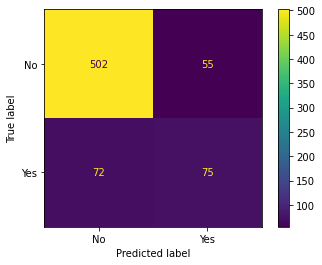

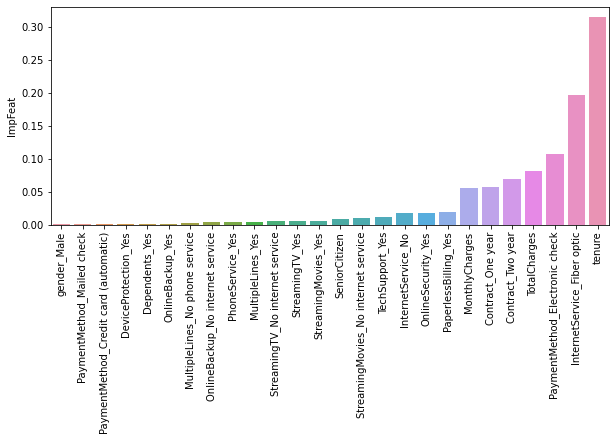

In [81]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(random_state=101)

from sklearn.model_selection import GridSearchCV
param_grid = {'n_estimators':[100],
              'min_samples_split':[0.01]
             }

gb_grid = GridSearchCV(gb,param_grid,cv=10,scoring='recall_macro',n_jobs=8)
gb_grid.fit(X_train,y_train)

post_process(gb_grid)